# <0. 필요 패키지 설치하기>

# <1-1. 필요 라이브러리 불러오기>

In [2]:
import os, sys ,math, copy, glob

import numpy as np
import pandas as pd
import scipy.io as sio

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import initializers, regularizers, constraints, utils
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# <1-2. 데이터 불러오기>

In [3]:
# 파일 경로 확인!
# train.csv 파일은 현재 실행한 CNC_network.ipynb 파일과 같은 폴더에 저장되어야 함
# 개별 생산 단위 데이터 파일 경로 설정
# CNC Virtual Data set _v2 폴더의 파일 경로 복사하여 path 의 ' '안에 붙여넣기

train_sample = pd.read_csv("./dataset/train.csv", header=0, encoding='utf-8')
path = "./dataset/CNC 비식별화 원본데이터_1209/"
all_files = glob.glob(path + "\*.csv")

# count the number of pass/fail items

train_sample_np = np.array(train_sample.copy())


# load csv file
li_df = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)    
    li_df.append(df)

# <2-1. 데이터 종류 확인>

In [4]:
print(colored("train_sample : ","red"))
display(train_sample)
print(colored("train_df : ","red"))
display(df)

train_sample : 


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,aluminum,6,4.0,unworn,yes,yes
1,2,aluminum,20,4.0,unworn,yes,yes
2,3,aluminum,6,3.0,unworn,yes,yes
3,4,aluminum,6,2.5,unworn,no,NaN
4,5,aluminum,20,3.0,unworn,no,NaN
5,6,aluminum,6,4.0,worn,yes,no
6,7,aluminum,20,4.0,worn,no,NaN
7,8,aluminum,20,4.0,worn,yes,no
8,9,aluminum,15,4.0,worn,yes,no
9,10,aluminum,12,4.0,worn,yes,no


train_df : 


,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_CurrentFeedback,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process
0,176.0,4.9750,-1.250,176.0,5.0,5.0,-1.420,0.0227,327,0.355,...,0.499,2.710000e-19,327,0.0,0.000003,17,1,2,50,Prep
1,176.0,5.0250,23.775,176.0,5.0,5.0,-1.740,0.0224,327,0.589,...,0.790,2.710000e-19,327,0.0,-0.000003,17,1,0,50,Prep
2,176.0,4.9750,-1.250,176.0,5.0,5.0,0.180,0.0329,327,2.190,...,-1.300,2.710000e-19,327,0.0,-0.000006,17,1,0,50,Prep
3,176.0,4.9625,-13.750,176.0,5.0,5.0,-0.619,0.0198,327,1.010,...,-3.810,2.710000e-19,327,0.0,0.000002,17,1,0,50,Prep
4,176.0,4.9750,-4.400,176.0,5.0,5.0,-0.779,0.0311,327,0.372,...,0.790,2.710000e-19,327,0.0,0.000000,17,1,0,50,Prep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,179.0,3.5625,8.150,179.0,3.5,5.0,-0.941,0.0215,328,1.790,...,0.244,2.770000e-19,328,0.0,-0.000003,17,1,0,20,End
561,178.5,3.5350,30.000,178.5,3.5,5.0,-0.780,0.0202,328,1.070,...,0.244,2.770000e-19,328,0.0,0.000000,17,1,0,20,End
562,178.5,3.5475,17.500,178.5,3.5,5.0,0.501,0.0190,328,0.990,...,0.128,2.770000e-19,328,0.0,0.000000,17,1,0,20,End
563,178.5,3.4475,11.250,178.5,3.5,5.0,-0.298,0.0193,328,1.370,...,0.657,2.770000e-19,328,0.0,-0.000008,17,1,0,20,End


In [5]:
print(colored("총 개별 생산 단위 데이터 개수 : ","red"),len(all_files), end="\n\n")
for idx, file in enumerate(all_files):
    print(colored(f"{idx}번째 파일 이름\t: ", "green"), file)

총 개별 생산 단위 데이터 개수 :  25

0번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_01.csv
1번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_02.csv
2번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_03.csv
3번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_04.csv
4번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_05.csv
5번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_06.csv
6번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_07.csv
7번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_08.csv
8번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_09.csv
9번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_10.csv
10번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_11.csv
11번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_12.csv
12번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_13.csv
13번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_14.csv
14번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_15.csv
15번째 파일 이름	:  ./dataset/CNC 비식별화 원본데이터_1209\experiment_

# <2-2 데이터 개수 확인>

In [6]:
# count the number of pass/fail items
nb_pass = 0
nb_pass_half = 0
nb_defective = 0
for i in range(len(train_sample_np)):
    if train_sample_np[i,5] == 'no':
        nb_defective += 1
    if train_sample_np[i,5] == 'yes' and train_sample_np[i,6] =='yes':
        nb_pass += 1
    if train_sample_np[i,5] == 'yes' and train_sample_np[i,6] == 'no':
        nb_pass_half += 1
        
print(colored("양품 샘플 개수 : ","red"), nb_pass)
print(colored("공정 마쳤으나 육안검사 통과 못한 샘플 개수 : ","red"), nb_pass_half)
print(colored("공정 중지된 샘플 개수 : ","red"), nb_defective)
print(colored("전체 샘플 개수 : ","red"), nb_pass + nb_pass_half + nb_defective)

양품 샘플 개수 :  13
공정 마쳤으나 육안검사 통과 못한 샘플 개수 :  6
공정 중지된 샘플 개수 :  6
전체 샘플 개수 :  25


# < 3-1. 사용자 정의 함수 선언 >

In [7]:
def tool_condition(input):
    for i in range(len(input)):
        if input[i,4] == 'unworn':
            input[i,4] = 0
        else:
            input[i,4] = 1
    return input

def item_inspection(input):
    for i in range(len(input)):
        if input[i,5] == 'no':
            input[i,6] = 2
        elif input[i,5] == 'yes' and input[i,6] == 'no':
            input[i,6] = 1
        elif input[i,5] == 'yes' and input[i,6] == 'yes':
            input[i,6] = 0
    return input


def machining_process(input):
    for i in range(len(input)):
        if input[i,47] == 'Prep':
            input[i,47] = 0
        elif input[i,47] == 'Layer 1 Up':
            input[i,47] = 1
        elif input[i,47] == 'Layer 1 Down':
            input[i,47] = 2
        elif input[i,47] == 'Layer 2 Up':
            input[i,47] = 3
        elif input[i,47] == 'Layer 2 Down':
            input[i,47] = 4
        elif input[i,47] == 'Layer 3 Up':
            input[i,47] = 5
        elif input[i,47] == 'Layer 3 Down':
            input[i,47] = 6
        elif input[i,47] == 'Repositioning':
            input[i,47] = 7
        elif input[i,47] == 'End' or 'end':
            input[i,47] = 8        
        elif input[i,47] == 'Starting':
            input[i,47] = 9
    return input


# <3-2. 사용자 정의 함수의 사용을 통한 데이터 분류>

In [8]:
# Modifying train.csv for training, 
# - [tool_condition]  : unworn/worn -> 0 / 1 
# - [item_inspection] : machining_finalized & passed -> yes & yes / yes & no / no : 0 / 1 / 2
# - delete 'material' column and 'No' column

train_sample_info = np.array(train_sample_np.copy())
train_sample_info = tool_condition(train_sample_info)
train_sample_info = item_inspection(train_sample_info)
print(train_sample_info[:2])

#[feedrate  clamp_pressure  unworn/worn  label]

[[1 'aluminum' 6 4.0 0 'yes' 0]
 [2 'aluminum' 20 4.0 0 'yes' 0]]


In [9]:
train_sample_info = np.delete(train_sample_info,5,1)
train_sample_info = np.delete(train_sample_info,0,1)
train_sample_info = np.delete(train_sample_info,0,1)
print(train_sample_info[:2])

[[6 4.0 0 0]
 [20 4.0 0 0]]


In [10]:
k  = 0
li_pass = []
li_pass_half = []
li_fail = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)      
    
    if train_sample_info[k,3] == 0:
        li_pass.append(df)        
    elif train_sample_info[k,3] == 1:
        li_pass_half.append(df)        
    else :
        li_fail.append(df)
        
    k += 1
    
frame01 = pd.concat(li_pass, axis=0, ignore_index=True)
frame02 = pd.concat(li_pass_half, axis=0, ignore_index=True)
frame03 = pd.concat(li_fail, axis=0, ignore_index=True)

data_pass = np.array(frame01.copy())
data_pass_half = np.array(frame02.copy())
data_fail = np.array(frame03.copy())

data_pass = machining_process(data_pass)
data_pass_half = machining_process(data_pass_half)
data_fail = machining_process(data_fail)

print("Data_length")
print(colored("공정완료 및 육안검사 합격한 전체 데이터 수 : ","red"),len(data_pass))
print(colored("공정완료 및 육안검사 불합격한 전체 데이터 수 : ","red"), len(data_pass_half))
print(colored("공정 미완료한 전체 데이터 수 : ","red"), len(data_fail))
print("\nData_shape")
print(colored("공정완료 및 육안검사 합격한 전체 데이터 shape : ","red"),data_pass.shape)
print(colored("공정완료 및 육안검사 불합격한 전체 데이터 shape : ","red"),data_pass_half.shape)
print(colored("공정 미완료한 전체 데이터 shape : ","red"),data_fail.shape)

Data_length
공정완료 및 육안검사 합격한 전체 데이터 수 :  22645
공정완료 및 육안검사 불합격한 전체 데이터 수 :  6175
공정 미완료한 전체 데이터 수 :  3228

Data_shape
공정완료 및 육안검사 합격한 전체 데이터 shape :  (22645, 48)
공정완료 및 육안검사 불합격한 전체 데이터 shape :  (6175, 48)
공정 미완료한 전체 데이터 shape :  (3228, 48)


# <3-3. 데이터셋 구성>

In [11]:
# label 0/1 --> data01 / data02+data03

data01 = data_pass[0:3228+6175,:]
data02 = data_pass_half[0:6175,:]
data03 = data_fail[0:3228,:]

data = np.concatenate((data01,data02),axis=0);
data = np.concatenate((data,data03),axis=0);

data_all= data_pass[3228+6175:22645,:]

print("Data_shape")
print(colored("data shape : ","red"),data.shape)
print(colored("data_all shape : ","red"),data_all.shape)

print("\nData_sample : ", data[0])

Data_shape
data shape :  (18806, 48)
data_all shape :  (13242, 48)

Data_sample :  [202.0 4.0 4.0 202.0 4.0 4.0 0.18 0.0207 329 2.77 -1.42e-06 162.0 3.975
 -2.25 162.0 4.0 4.0 0.539 0.0167 328 1.84 6.43e-07 123.0 4.0 4.0 123.0
 4.0 4.0 0 0 0 0 -357.0 4.001 4.25 -357.0 4.0 4.0 0.524 2.74e-19 329 0.0
 6.96e-07 16 1 0 50 8]


# <3-4. 데이터 정제 (2차 전처리)>

In [12]:
# 2차 전처리 진행, MinMaxScaler 사용
sc = MinMaxScaler()
X_train = sc.fit_transform(data)
X_train = np.array(X_train)
X_test = sc.fit_transform(data_all)
X_test = np.array(X_test)

# <4-1. 라벨 데이터 제작>

In [13]:
# 라벨 데이터 생성

Y_train = np.zeros((len(X_train),1),dtype='int')
Y_test = np.zeros((len(X_test),1),dtype='int')
l = int(Y_train.shape[0]/2)

Y_train[0:l,:] = 0
Y_train[l:l*2,:] = 1

# <5-1. 학습/검증/평가 데이터 구성>

In [14]:
# 뒤의 <7-1. AI 모델 훈련> 항목에 포함되어 있음

# <6-1. AI 모델 파라미터 설정>

In [15]:
nb_classes = 2
batch_size = 1024
epochs = 300
lr = 1e-3

# <6-2. 데이터셋 준비>

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = utils.to_categorical(Y_train, nb_classes)
Y_test = utils.to_categorical(Y_test, nb_classes)

print(colored("X_train shape\t: ","red"),X_train.shape)
print(colored("X_test shape\t: ","red"),X_test.shape)
print(colored("Y_train shape\t: ","red"),Y_train.shape)
print(colored("Y_test shape\t: ","red"),Y_test.shape)

X_train shape	:  (18806, 48)
X_test shape	:  (13242, 48)
Y_train shape	:  (18806, 2)
Y_test shape	:  (13242, 2)


# <6-3. AI 모델 디자인>

In [39]:
from tensorflow.keras import Sequential

print(colored('||.............................model is defined.............................||', "red"))
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=48))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt,loss=loss,metrics=['acc'])

model.summary()

||.............................model is defined.............................||
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               6272      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________

# <7-1. AI 모델 훈련>

In [37]:
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
ckp = tf.keras.callbacks.ModelCheckpoint("CNC_model.h5", save_best_only=True, monitor="val_acc")
ckp2 = tf.keras.callbacks.ModelCheckpoint("CNC_model2.h5", save_best_only=True, monitor="val_acc")
es = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=20)
R_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=4)
history = model.fit(X_train, Y_train, verbose=0, batch_size=batch_size, epochs=epochs, validation_split=0.1, shuffle=True, callbacks=[tqdm_callback, ckp, es,R_lr])

Training:   0%|                                                                               0/300 ETA: ?s,  …

In [40]:
model = tf.keras.models.load_model("CNC_model.h5")
loss_and_metrics = model.evaluate(X_train,Y_train,batch_size=32)
print(colored("early_stopping - train :","red"),loss_and_metrics)
loss_and_metrics2 = model.evaluate(X_test,Y_test,batch_size=32)
print(colored("early_stopping - test :","red"),loss_and_metrics2)

588/588 [==============================] - 1s 2ms/step - loss: 0.4166 - acc: 0.8268
early_stopping - train : [0.41658541560173035, 0.8268105983734131]
414/414 [==============================] - 1s 1ms/step - loss: 0.3942 - acc: 0.7611
early_stopping - test : [0.3942105174064636, 0.761063277721405]


In [41]:
history2 = model.fit(X_train, Y_train, verbose=0, batch_size=batch_size, epochs=epochs, validation_split=0.1, shuffle=True, callbacks=[tqdm_callback, ckp2,R_lr])

Training:   0%|                                                                               0/300 ETA: ?s,  …

In [42]:
model = tf.keras.models.load_model("CNC_model2.h5")
loss_and_metrics = model.evaluate(X_train,Y_train,batch_size=32)
print(colored("keep_going - train :","red"),loss_and_metrics)
loss_and_metrics2 = model.evaluate(X_test,Y_test,batch_size=32)
print(colored("keep_going - test :","red"),loss_and_metrics2)

588/588 [==============================] - 1s 1ms/step - loss: 0.1490 - acc: 0.9396
keep_going - train : [0.14904239773750305, 0.9395937323570251]
414/414 [==============================] - 1s 1ms/step - loss: 0.4734 - acc: 0.9044
keep_going - test : [0.4734385013580322, 0.9043951034545898]


# <8-1. AI 모델 훈련 결과 출력>

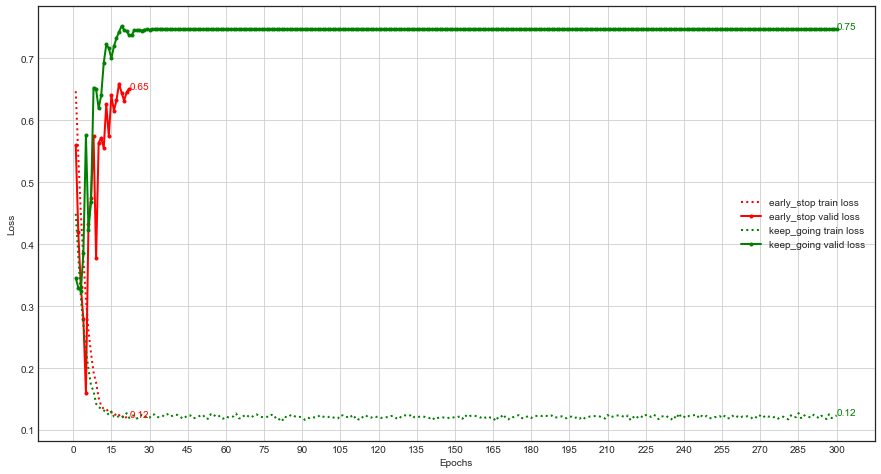

In [43]:
from Myfunc import show_lcurve
show_lcurve([history,history2], ["early_stop", "keep_going"],x_itv=15, size=(15,8), lw=2)

# Pycaret 이용하기

In [17]:
from pycaret.classification import *

In [73]:
frame01 = pd.concat(li_pass, axis=0, ignore_index=True)
frame02 = pd.concat(li_pass_half, axis=0, ignore_index=True)
frame03 = pd.concat(li_fail, axis=0, ignore_index=True)

data01 = frame01[0:3228+6175]
data02 = frame02[0:6175]
data03 = frame03[0:3228]

train_df = pd.concat([data01,data02],axis=0);
train_df = pd.concat([train_df,data03],axis=0);

test_df= frame01[3228+6175:22645]

Y_train = np.zeros((len(train_df),1),dtype='int')
Y_test = np.zeros((len(test_df),1),dtype='int')
l = int(Y_train.shape[0]/2)

Y_train[0:l,:] = 0
Y_train[l:l*2,:] = 1

train_df["target"] = Y_train

In [74]:
train_df

,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process,target
0,202.0,4.000,4.000,202.0,4.00,4.000000,0.180,0.0207,329,2.770,...,2.740000e-19,329,0.0,6.960000e-07,16.0,1,0,50,Starting,0
1,202.0,-6.800,-346.000,202.0,-9.60,-354.000000,-10.900,0.1860,328,23.300,...,2.740000e-19,328,0.0,-5.270000e-07,16.0,1,4,50,Prep,0
2,200.0,-13.800,-2.250,200.0,-13.90,3.999905,-8.590,0.1400,328,30.600,...,2.740000e-19,328,0.0,9.100000e-07,16.0,1,7,50,Prep,0
3,198.0,-14.000,4.000,198.0,-13.90,3.999905,-6.110,0.1300,327,30.300,...,2.740000e-19,328,0.0,1.070000e-06,16.0,1,7,50,Prep,0
4,197.0,-13.900,-14.800,196.0,-13.90,4.000095,-5.700,0.1140,328,30.500,...,2.740000e-19,328,0.0,1.960000e-06,16.0,1,7,50,Prep,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,154.0,9.900,19.650,154.0,9.95,6.920000,0.555,0.0226,327,2.220,...,2.770000e-19,326,0.0,0.000000e+00,16.0,1,0,50,End,1
3224,154.5,9.650,22.750,154.5,10.00,4.000000,1.670,0.0268,327,3.000,...,2.770000e-19,326,0.0,0.000000e+00,16.0,1,0,50,End,1
3225,155.0,9.875,-64.600,155.0,10.00,4.000000,0.544,0.0274,327,1.510,...,2.770000e-19,327,0.0,-2.050000e-06,16.0,1,0,50,End,1
3226,155.5,9.950,-52.125,155.5,10.00,4.000000,1.100,0.0275,327,1.900,...,2.770000e-19,326,0.0,1.930000e-06,16.0,1,0,50,End,1


In [66]:
s = setup(train_df, target = 'target', train_size=0.9)

,Description,Value
0,session_id,3839
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(18806, 49)"
5,Missing Values,False
6,Numeric Features,39
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [67]:
best = compare_models(n_select=3, sort="Accuracy")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9985,1.0000,0.9988,0.9982,0.9985,0.9970,0.9970,0.1070
xgboost,Extreme Gradient Boosting,0.9982,1.0000,0.9986,0.9979,0.9982,0.9965,0.9965,0.6570
catboost,CatBoost Classifier,0.9976,1.0000,0.9983,0.9968,0.9976,0.9952,0.9952,2.4650
rf,Random Forest Classifier,0.9955,0.9999,0.9963,0.9946,0.9954,0.9909,0.9909,0.1950
et,Extra Trees Classifier,0.9952,0.9999,0.9954,0.9950,0.9952,0.9904,0.9904,0.1500
dt,Decision Tree Classifier,0.9905,0.9905,0.9909,0.9902,0.9905,0.9811,0.9811,0.0480
gbc,Gradient Boosting Classifier,0.9815,0.9990,0.9820,0.9809,0.9814,0.9630,0.9630,0.8620
ada,Ada Boost Classifier,0.9597,0.9941,0.9554,0.9634,0.9594,0.9194,0.9195,0.2000
lda,Linear Discriminant Analysis,0.9020,0.9671,0.9068,0.8976,0.9022,0.8040,0.8040,0.1040
ridge,Ridge Classifier,0.9019,0.0000,0.9075,0.8969,0.9021,0.8037,0.8038,0.0210


In [68]:
blender = blend_models(estimator_list=best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9976,0.9999,0.9976,0.9976,0.9976,0.9953,0.9953
1,0.9988,1.0000,1.0000,0.9976,0.9988,0.9976,0.9976
2,0.9976,1.0000,1.0000,0.9953,0.9976,0.9953,0.9953
3,0.9994,1.0000,0.9988,1.0000,0.9994,0.9988,0.9988
4,0.9970,1.0000,0.9988,0.9953,0.9970,0.9941,0.9941
5,0.9970,1.0000,0.9976,0.9964,0.9970,0.9941,0.9941
6,0.9988,1.0000,0.9988,0.9988,0.9988,0.9976,0.9976
7,0.9988,1.0000,0.9988,0.9988,0.9988,0.9976,0.9976
8,0.9994,1.0000,1.0000,0.9988,0.9994,0.9988,0.9988


In [69]:
final = finalize_model(blender)

In [70]:
y_pred = predict_model(final, data=test_df)

In [72]:
Y_test = np.zeros((len(X_test),1),dtype='int')

Test Acc	: 0.8091677994260685 


Classfication_report :
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     13242
           1       0.00      0.00      0.00         0

    accuracy                           0.81     13242
   macro avg       0.50      0.40      0.45     13242
weighted avg       1.00      0.81      0.89     13242



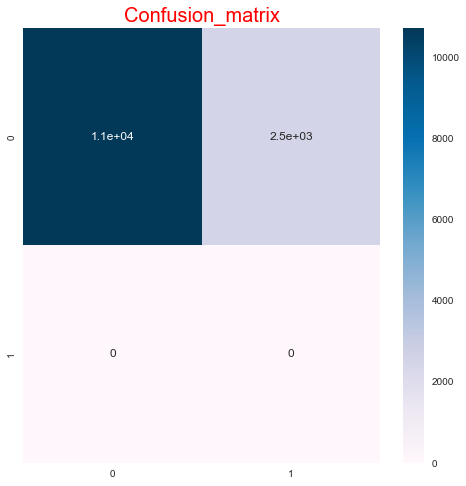

In [78]:
print(colored("Test Acc\t:","red"),accuracy_score(Y_test, y_pred["Label"]),"\n\n")
print(colored("Classfication_report :\n", "red"), classification_report(Y_test, y_pred["Label"]))
plt.figure(figsize=(8,8))
plt.title("Confusion_matrix", fontsize=20, color="red")
sns.heatmap(confusion_matrix(Y_test, y_pred["Label"]), annot=True, cmap="PuBu");